In [1]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import random

In [2]:
borders = np.load('map-borders.npy')
borders

array([[55.1471993 , 36.75571401],
       [56.0785417 , 38.06930099]])

In [3]:
matrix = np.load('matrix-32.npy')

In [4]:
def get_covered_index(x, left, right, steps):
    length = right - left
    shift = x - left
    step_size = length / steps
    relative_position = shift / length
    index = math.floor(relative_position * steps)
    return index

def get_selection_rects(selection, matrix, borders):
    (lat_min, lng_min), (lat_max, lng_max) = borders
    (sel_lat_min, sel_lng_min), (sel_lat_max, sel_lng_max) = selection
    if sel_lat_min > sel_lat_max or sel_lng_min > sel_lng_max:
        raise Exception('Selection must be sorted (min_lat, min_lng), (max_lat, max_lng)')
    lat_n = matrix.shape[0]
    lng_n = matrix.shape[1]
    lat_step = (lat_max - lat_min) / lat_n
    lng_step = (lng_max - lng_min) / lng_n
    
    sel_vert_index_min = min(max(get_covered_index(sel_lat_min, lat_min, lat_max, lat_n), 0), lat_n - 1)
    sel_hor_index_min = min(max(get_covered_index(sel_lng_min, lng_min, lng_max, lng_n), 0), lng_n - 1)
    sel_vert_index_max = min(max(get_covered_index(sel_lat_max, lat_min, lat_max, lat_n), 0), lat_n - 1)
    sel_hor_index_max = min(max(get_covered_index(sel_lng_max, lng_min, lng_max, lng_n), 0), lng_n - 1)
    
    result_borders = (
        (
            lat_min + lat_step * sel_vert_index_min,
            lng_min + lng_step * sel_hor_index_min
        ), (
            lat_min + lat_step * (sel_vert_index_max + 1),
            lng_min + lng_step * (sel_hor_index_max + 1)
        )
    )
    result_matrix = np.zeros((
        sel_vert_index_max - sel_vert_index_min + 1,
        sel_hor_index_max - sel_hor_index_min + 1
    ))
    for i in range(result_matrix.shape[0]):
        for j in range(result_matrix.shape[1]):
            result_matrix[i][j] = matrix[sel_vert_index_min + i][sel_hor_index_min + j]

    return result_borders, result_matrix

In [5]:
rect, submatrix = get_selection_rects(((55, 36), (57, 38)), matrix, borders)

In [6]:
def plot_density_matrix(matrix):
    matrix = np.array(matrix)
    plt.figure(figsize=(8, 8 / matrix.shape[1] * matrix.shape[0]))
    sns.heatmap(np.log1p(matrix), vmin=0, vmax=11, cbar=False)
    plt.gca().invert_yaxis()
    plt.show()

In [7]:
def plot_ax_density_matrix(ax, matrix):
    matrix = np.array(matrix)
    matrix = np.log1p(matrix)
    sns.heatmap(matrix, ax=ax, vmin=0, vmax=11, cbar=False)
    ax.invert_yaxis()

In [8]:
def plot_2_density_matrixes(m1, m2):
    fig, axs = plt.subplots(1, 2, figsize=(16, 8 / matrix.shape[1] * matrix.shape[0]))
    plot_ax_density_matrix(axs[0], m1)
    plot_ax_density_matrix(axs[1], m2)
    plt.tight_layout()
    plt.show()

In [9]:
def backend_request(min_lat, min_lng, max_lat, max_lng):
    return requests.get(
        'http://host.docker.internal:5000'
        '/heatmap/population-density?'
        f'minLat={min_lat}&'
        f'minLng={min_lng}&'
        f'maxLat={max_lat}&'
        f'maxLng={max_lng}'
    ).json()

In [10]:
def select_zoom_level(borders, min_lat, min_lng, max_lat, max_lng):
    zoom_lat = (borders[1][0] - borders[0][0]) / (max_lat - min_lat)
    zoom_lng = (borders[1][1] - borders[0][1]) / (max_lng - min_lng)
    zoom = max(zoom_lat, zoom_lng)
    power_of_2 = int(np.log2(zoom) + 5.5)
    size = 2 ** power_of_2
    size = max(min(2048, size), 32)
    return size

In [11]:
def python_request(min_lat, min_lng, max_lat, max_lng):
    borders = np.load('map-borders.npy')
    matrix_size = select_zoom_level(borders, min_lat, min_lng, max_lat, max_lng)
    print(f'Matrix size: {matrix_size}')
    matrix = np.load(f'matrix-{matrix_size}.npy')
    return get_selection_rects(((min_lat, min_lng), (max_lat, max_lng)), matrix, borders)

In [27]:
def plot_random_crop():
    borders = np.load('map-borders.npy')
    (min_lat, min_lng), (max_lat, max_lng) = borders
    height = max_lat - min_lat
    width = max_lng - min_lng
    rand = lambda: random.random()
    size = rand() * 0.1
    print(f'Size: {size:.2f}')
    lat_shift = (1 - size) * rand()
    lng_shift = (1 - size) * rand()
    lat1 = min_lat + height * lat_shift
    lng1 = min_lng + width * lng_shift
    lat2 = min_lat + height * (lat_shift + size)
    lng2 = min_lng + width * (lng_shift + size)
    if lat1 > lat2:
        lat1, lat2 = lat2, lat1
    if lng1 > lng2:
        lng1, lng2 = lng2, lng1
    res = backend_request(lat1, lng1, lat2, lng2)
    borders, matrix2 = python_request(lat1, lng1, lat2, lng2)
#     print(f"API rect: {res['geoRect']}")
#     print(f"Py rect: {borders}")
    plot_2_density_matrixes(res['matrix'], matrix2)

Size: 0.06
Matrix size: 512


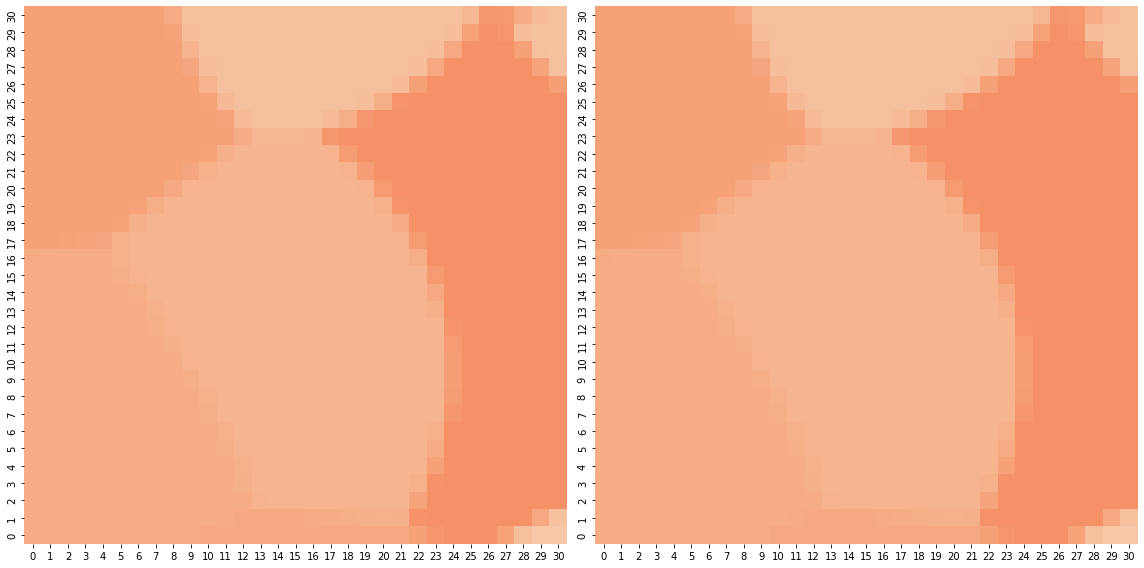

In [37]:
plot_random_crop()